In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from statsmodels.tsa.arima.model import ARIMA
import shap

/home/adelchiasta/venv/venv_chem_insights/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!ls

'Background materials for interview.pdf'   requirements.txt
 chemical_reaction_model.ipynb		   TestDatabase.xlsx


In [3]:
df = pd.read_excel("TestDatabase.xlsx")
print(df.shape)
df.head()

(28814, 13)


,conti_Ca,conti_Cb,conti_Ca_in,conti_Tsp,conti_m_in,conti_mfree_A_liq,conti_mfree_B_liq,conti_mfree_A_gas,conti_mfree_B_gas,conti_Pinert,conti_P_A,conti_P_B,conti_Ptot
0,12.500000,0.000000,13.062965,357.047056,2.0,35000.000000,0.000000,3500.000000,0.000000,100000.0,8.658575e+06,0.000000,8.758575e+06
1,12.393228,0.107255,13.062965,357.047056,2.0,34701.037604,225.234700,3470.103760,22.523470,100000.0,8.584615e+06,74293.771118,8.758909e+06
2,12.287463,0.213502,13.062965,357.047056,2.0,34404.895408,448.353382,3440.489541,44.835338,100000.0,8.511353e+06,147889.572820,8.759243e+06
3,12.182695,0.318750,13.062965,NaN,2.0,34111.546805,669.376002,3411.154681,66.937600,100000.0,8.438782e+06,220793.987390,8.759576e+06
4,12.078916,0.423011,13.062965,NaN,2.0,33820.965450,888.322320,3382.096545,88.832232,100000.0,8.366896e+06,293013.532865,8.759909e+06


# **GOAL**: For the operator in charge of the process, it is important to understand how the concentrations of the products (conti_Ca & conti_Cb) in the outgoing flows evolve as a function of all other parameters. 
# model **conti_Ca_in** with the remaining parameters and predict **conti_Cb** and **conti_Ca** with a regression mode in two separate models

In [4]:
# Assuming your DataFrame is named 'df'
# Replace 'your_column_names' with the actual names of your columns

def custom_describe(df):
    summary_stats = pd.DataFrame(index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing'])

    for column in df.columns:
        column_stats = []

        # Count (including missing values)
        count_with_missing = len(df[column])
        column_stats.append(count_with_missing)

        # Mean
        mean = df[column].mean()
        column_stats.append(mean)

        # Standard Deviation
        std = df[column].std()
        column_stats.append(std)

        # Min
        min_value = df[column].min()
        column_stats.append(min_value)

        # Percentiles
        percentiles = df[column].describe(percentiles=[.25, .5, .75])
        column_stats.extend(percentiles.loc[['25%', '50%', '75%']])

        # Max
        max_value = df[column].max()
        column_stats.append(max_value)

        # Missing values
        missing_values = df[column].isnull().sum()
        column_stats.append(missing_values)

        summary_stats[column] = column_stats

    return summary_stats

# Use the custom_describe function
result = custom_describe(df)

# Display the result
result

,conti_Ca,conti_Cb,conti_Ca_in,conti_Tsp,conti_m_in,conti_mfree_A_liq,conti_mfree_B_liq,conti_mfree_A_gas,conti_mfree_B_gas,conti_Pinert,conti_P_A,conti_P_B,conti_Ptot
count,28814.000000,28814.000000,28814.000000,28814.000000,28814.000000,28814.000000,28814.000000,28814.000000,28814.000000,28814.000000,2.881400e+04,2.881400e+04,2.881400e+04
mean,1.922393,10.406138,12.316871,342.111382,1.998974,5360.959562,21893.577793,535.748079,2182.266352,95822.416647,1.178100e+06,6.990810e+06,8.281141e+06
std,1.787991,1.890978,1.465869,39.715066,0.045287,4945.897532,3930.220657,499.628285,398.065655,11108.186700,1.062159e+06,1.840688e+06,1.037761e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,6.137713e+06
25%,0.383703,9.325844,11.022312,310.289243,2.000000,1082.743302,19681.953990,99.455091,1954.156648,86904.299628,2.610664e+05,5.614513e+06,7.408385e+06
50%,1.432586,10.809126,12.263535,343.752171,2.000000,4027.579484,22693.026412,400.794092,2268.253785,97431.355818,9.124696e+05,6.983922e+06,8.341341e+06
75%,2.953676,11.746921,13.485383,379.700172,2.000000,8270.495996,24693.040264,829.688187,2467.542197,106344.574410,1.794184e+06,8.473851e+06,8.986956e+06
max,12.500000,13.687907,14.922942,407.278453,2.000000,35000.000000,28744.604631,3500.000000,2874.460463,114068.565048,8.658575e+06,1.066725e+07,1.086888e+07
missing,1056.000000,1916.000000,1975.000000,1820.000000,1522.000000,2059.000000,2217.000000,1704.000000,1355.000000,1544.000000,1.360000e+03,1.710000e+03,1.309000e+03


# 1.a. Data Sampling

## Potential Benefits:

* Increased Temporal Resolution: Smaller time intervals provide a more detailed view of the data, allowing for better understanding of short-term variations and patterns in the underlying process.

* Improved Visualization: Higher frequency data can lead to smoother visualizations, especially when plotting time series data. This can be particularly helpful for identifying trends, cycles, or irregularities.

* Enhanced Modeling: Some models, especially those designed for high-frequency data, may perform better when trained on more granular time intervals. For example, machine learning models that capture short-term dependencies might benefit from higher frequency.

* Better Analysis of Fast-Changing Phenomena: If the underlying process is dynamic and changes rapidly, higher-frequency data can help capture and analyze these changes more accurately.

## Potential Downsides:

* Increased Data Volume: Higher frequency data results in more data points, which can be computationally expensive and may require more storage. This can be a consideration, especially for large datasets.

* Noise and Variability: Smaller time intervals may capture more noise or short-term fluctuations that are not relevant to the overall analysis. This can make it challenging to distinguish between meaningful patterns and random variations.

* Computational Cost: Performing analyses and running models on data with smaller time intervals may be more computationally intensive and time-consuming, especially if not all the additional details are necessary for the specific analysis.

* Data Quality Issues: Depending on the nature of the data collection process, increasing frequency may introduce missing values or inconsistencies, which need to be handled appropriately during resampling.

* Interpretability: Extremely high-frequency data can sometimes make it more challenging to interpret and extract meaningful insights, especially for users who are not familiar with the domain.

# 3.a. Correlation matrix 

In [5]:
def pearson_correlation(X):
    data = X
    corr_pearson = data.corr(method='pearson')
    plt.subplots(figsize=(15,10))
    sns.heatmap(corr_pearson)
    # drop correlated feature
    # Return a new array of given shape and type, filled with fill_value.
    columns = np.full((corr_pearson.shape[0],), True, dtype=bool) 
    for i in range(corr_pearson.shape[0]):
        for j in range(i+1, corr_pearson.shape[0]):
            if corr_pearson.iloc[i,j] >= 0.75:
                if columns[j]:
                    columns[j] = False
    selected_columns_pearson = data.columns[columns]
    return selected_columns_pearson, corr_pearson

def spearman_correlation(X):
    data = X
    corr_spearman = data.corr(method='spearman')
    plt.subplots(figsize=(15,10))
    sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    # Returns a new array of given shape and type, filled with fill_value.
    columns = np.full((corr_spearman.shape[0],), True, dtype=bool) 
    for i in range(corr_spearman.shape[0]):
        for j in range(i+1, corr_spearman.shape[0]):
            if corr_spearman.iloc[i,j] >= 0.75:
                if columns[j]:
                    columns[j] = False
    selected_columns_spearman = data.columns[columns]
    return selected_columns_spearman, corr_spearman

(Index(['conti_Ca', 'conti_Cb', 'conti_Ca_in', 'conti_Tsp', 'conti_m_in'], dtype='object'),
                    conti_Ca  conti_Cb  conti_Ca_in  conti_Tsp  conti_m_in  \
 conti_Ca           1.000000 -0.921903    -0.009878  -0.735159    0.039949   
 conti_Cb          -0.921903  1.000000     0.133701   0.669106    0.040657   
 conti_Ca_in       -0.009878  0.133701     1.000000   0.088124    0.040677   
 conti_Tsp         -0.735159  0.669106     0.088124   1.000000    0.040569   
 conti_m_in         0.039949  0.040657     0.040677   0.040569    1.000000   
 conti_mfree_A_liq  1.000000 -0.921478     0.004202  -0.728513    0.040703   
 conti_mfree_B_liq -0.922602  1.000000     0.100239   0.675818    0.040826   
 conti_mfree_A_gas  1.000000 -0.923177     0.004850  -0.736597    0.040365   
 conti_mfree_B_gas -0.922787  1.000000     0.119795   0.659986    0.040203   
 conti_Pinert      -0.738270  0.665400     0.072496   1.000000    0.040328   
 conti_P_A          0.996673 -0.915857     0.01359

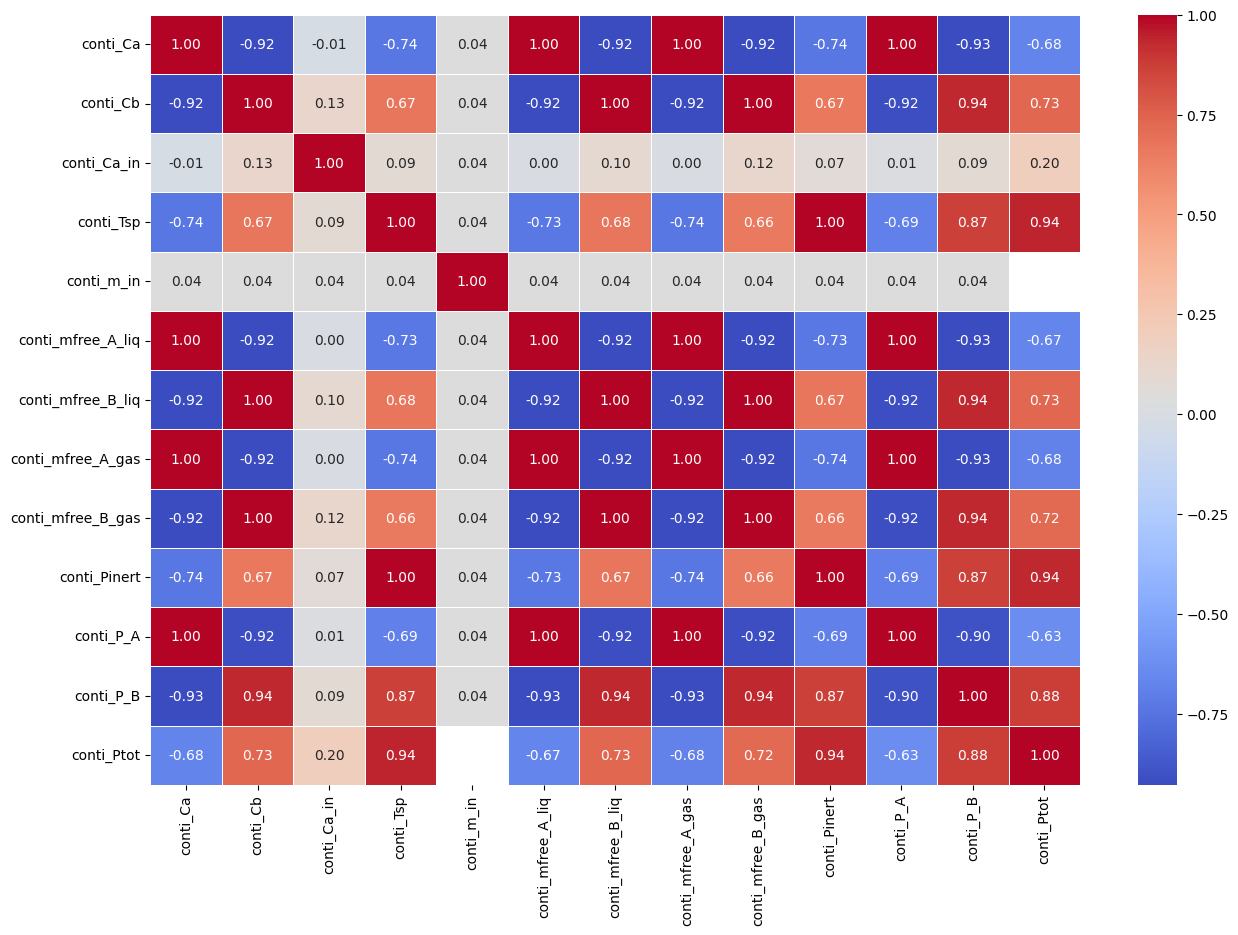

In [6]:
spearman_correlation(df)

# 2. Small vs large gaps treatment

In [7]:
# Create a timestamp column based on the assumption that rows are 15 seconds apart
df['timestamp'] = pd.date_range(start='2024-01-01', periods=len(df), freq='15S')
df['timestamp_diff'] = df['timestamp'].diff()

# Set the threshold for large gaps
large_gap_threshold = pd.Timedelta(minutes=9)

# Identify gaps equal or larger than 9 minutes for each column
large_gaps_columns = {}
for column in df.columns:
    large_gaps_columns[column] = df[df[column].isnull() & (df['timestamp_diff'] >= large_gap_threshold)]

# Drop the temporary 'timestamp_diff' column
df.drop(columns=['timestamp_diff'], inplace=True)

# Display the timestamps and the columns with missing values larger than 9 minutes
print("Gaps with Missing Values >= 9 Minutes for Each Column:")
for column, large_gaps in large_gaps_columns.items():
    print(f"Column: {column}")
    print(large_gaps[['timestamp']])
    print()

Gaps with Missing Values >= 9 Minutes for Each Column:
Column: conti_Ca
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_Cb
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_Ca_in
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_Tsp
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_m_in
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_mfree_A_liq
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_mfree_B_liq
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_mfree_A_gas
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_mfree_B_gas
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_Pinert
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_P_A
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_P_B
Empty DataFrame
Columns: [timestamp]
Index: []

Column: conti_Ptot
Empty DataFrame
Columns: [timestamp]
Index: []

Column: timestamp
Empty DataFrame
Columns: [timest

'S' is deprecated and will be removed in a future version, please use 's' instead.


### Conclusion: 
There is no gap larger than 9 min 

# 1.b. Resampled dataset

In [8]:
# Create a timestamp column based on the assumption that rows are 15 seconds apart
df['timestamp'] = pd.date_range(start='2024-01-01', periods=len(df), freq='15S')

# Set the timestamp column as the index
df.set_index('timestamp', inplace=True)

# Resample the DataFrame with a 5-second interval
df_resampled = df.resample('5S').ffill()  # Use 'ffill' to forward fill missing values

# Reset the index to make 'timestamp' a regular column again
df_resampled.reset_index(inplace=True)

'S' is deprecated and will be removed in a future version, please use 's' instead.
'S' is deprecated and will be removed in a future version, please use 's' instead.


In [9]:
print(df_resampled.timestamp.min())
print(df_resampled.timestamp.max())

2024-01-01 00:00:00
2024-01-06 00:03:15


Conclusion: The information regarding the period of measurement being roughly 5 days was verified.

In [10]:
df_resampled.fillna(method='ffill', inplace=True)

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


In [11]:
df_resampled.isnull().sum()

timestamp            0
conti_Ca             0
conti_Cb             0
conti_Ca_in          0
conti_Tsp            0
conti_m_in           0
conti_mfree_A_liq    0
conti_mfree_B_liq    0
conti_mfree_A_gas    0
conti_mfree_B_gas    0
conti_Pinert         0
conti_P_A            0
conti_P_B            0
conti_Ptot           0
dtype: int64

# 3. Removal of highly correlated features

In [12]:
def spearman_correlation(X, threshold):
    data = X
    corr_spearman = data.corr(method='spearman')
    # plt.subplots(figsize=(15,10))
    # sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    # Returns a new array of given shape and type, filled with fill_value.
    columns = np.full((corr_spearman.shape[0],), True, dtype=bool) 
    for i in range(corr_spearman.shape[0]):
        for j in range(i+1, corr_spearman.shape[0]):
            if corr_spearman.iloc[i,j] >= threshold:
                if columns[j]:
                    columns[j] = False
    selected_columns_spearman = data.columns[columns]
    return selected_columns_spearman, corr_spearman

selected_columns_spearman, corr_spearman = spearman_correlation(df_resampled.drop(columns=['conti_Ca', 'conti_Ca_in', 'conti_Cb','timestamp']), 0.8)
selected_columns_spearman

Index(['conti_Tsp', 'conti_m_in', 'conti_mfree_A_liq', 'conti_mfree_B_liq'], dtype='object')

# 4. Cross-validation and validation

In [13]:
def cross_validation(X_train, y_train, model=RandomForestRegressor(n_estimators=50, random_state=42), k_value='all', feature_selection=False):
    # Assuming you have a regression dataset named 'regression_df'
    X_reg = X_train.copy()  # Exclude the target variable from features
    y_reg = y_train.copy()

    if feature_selection:
        steps_reg = [
                        ('feature_selection', SelectKBest(score_func=f_regression, k=k_value)),  # Feature selection based on correlation
                        ('model', model)  # Replace with your regression model
                    ]
    else:
        # Define the steps for the pipeline
        steps_reg = [
            ('model', model)  # Replace with your regression model
        ]
    
    # Create the regression pipeline
    pipeline_reg = Pipeline(steps_reg)
    
    # Use TimeSeriesSplit for time series cross-validation
    tscv_reg = TimeSeriesSplit(n_splits=5)
    
    # Specify the scoring metrics for regression
    scoring_metrics_reg = {
        'neg_mean_squared_error': 'neg_mean_squared_error',
        'neg_mean_absolute_error': 'neg_mean_absolute_error',
        'r2': 'r2'
    }
    
    # Use cross_validate for cross-validation with multiple scoring metrics
    cv_results_reg = cross_validate(pipeline_reg, X_reg, y_reg, cv=tscv_reg, scoring=scoring_metrics_reg,
                                    verbose=1, n_jobs=-1, return_train_score=True)
    
    # Access the results for each metric
    mse_scores = cv_results_reg['test_neg_mean_squared_error']
    mae_scores = cv_results_reg['test_neg_mean_absolute_error']
    r2_scores = cv_results_reg['test_r2']
    
    # Print or store the cross-validation results for the metrics
    print(f'Cross-Validation Mean Squared Error Scores: {mse_scores}')
    print(f'Mean Mean Squared Error: {np.mean(mse_scores)}')
    
    print(f'Cross-Validation Mean Absolute Error Scores: {mae_scores}')
    print(f'Mean Mean Absolute Error: {np.mean(mae_scores)}')
    
    print(f'Cross-Validation R^2 Scores: {r2_scores}')
    print(f'Mean R^2: {np.mean(r2_scores)}')
    return cv_results_reg, pipeline_reg

In [14]:
# def cross_validation_features_dropping(X_train, y_train, model=RandomForestRegressor(n_estimators=50, random_state=42), threshold=0.8):
#     # Assuming you have a regression dataset named 'regression_df'
#     X_reg = X_train.copy()  # Exclude the target variable from features
#     y_reg = y_train.copy()
    
#     # Identify highly correlated features and drop them
#     corr_matrix = X_reg.corr().abs()
#     upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1)
#     to_drop = [column for column in corr_matrix.columns if any(corr_matrix[column] > threshold) and any(upper_triangle[:, corr_matrix.columns.get_loc(column)])]
#     removed_features = X_reg.columns[X_reg.columns.isin(to_drop)].tolist()
#     kept_features = X_reg.columns[~X_reg.columns.isin(to_drop)].tolist()
#     X_reg = X_reg.drop(columns=to_drop)
    
#     # Define the steps for the pipeline
#     steps_reg = [
#         ('model', model)  # Replace with your regression model
#     ]
    
#     # Create the regression pipeline
#     pipeline_reg = Pipeline(steps_reg)
    
#     # Use TimeSeriesSplit for time series cross-validation
#     tscv_reg = TimeSeriesSplit(n_splits=5)
    
#     # Specify the scoring metrics for regression
#     scoring_metrics_reg = {
#         'neg_mean_squared_error': 'neg_mean_squared_error',
#         'neg_mean_absolute_error': 'neg_mean_absolute_error',
#         'r2': 'r2'
#     }
    
#     # Use cross_validate for cross-validation with multiple scoring metrics
#     cv_results_reg = cross_validate(pipeline_reg, X_reg, y_reg, cv=tscv_reg, scoring=scoring_metrics_reg,
#                                     verbose=1, n_jobs=-1, return_train_score=True)
    
#     # Access the results for each metric
#     mse_scores = cv_results_reg['test_neg_mean_squared_error']
#     mae_scores = cv_results_reg['test_neg_mean_absolute_error']
#     r2_scores = cv_results_reg['test_r2']
    
#     # Print or store the cross-validation results for the metrics
#     print(f'Cross-Validation Mean Squared Error Scores: {mse_scores}')
#     print(f'Mean Mean Squared Error: {np.mean(mse_scores)}')
    
#     print(f'Cross-Validation Mean Absolute Error Scores: {mae_scores}')
#     print(f'Mean Mean Absolute Error: {np.mean(mae_scores)}')
    
#     print(f'Cross-Validation R^2 Scores: {r2_scores}')
#     print(f'Mean R^2: {np.mean(r2_scores)}')
    
#     # Output removed and kept features
#     print(f'Removed Features: {removed_features}')
#     print(f'Kept Features: {kept_features}')
    
#     return cv_results_reg, pipeline_reg


In [15]:
def check_validation(pipeline_reg, X_train, y_train, X_test, y_test):
    # Fit the regression pipeline on the training data
    pipeline_reg.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = pipeline_reg.predict(X_test)
    
    # Evaluate performance on the test set
    mse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    
    # Print or store the test set results
    print(f'Test Set Mean Squared Error: {mse_test}')
    print(f'Test Set Mean Absolute Error: {mae_test}')
    print(f'Test Set R^2: {r2_test}')
    return pipeline_reg


##  Model c_a

In [179]:
# Split the dataset into training and testing sets
df_resampled = df_resampled.sort_values('timestamp')
X_train, X_test, y_train, y_test = train_test_split(df_resampled.drop(columns=["conti_Cb", "conti_Ca", "timestamp"]), df_resampled["conti_Ca"], shuffle=False, test_size=0.2, random_state=42)

### Full dataframe no features removal 

In [139]:
cv_results_ca, pipeline_reg = cross_validation(X_train, y_train, RandomForestRegressor(n_estimators=50, random_state=42))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-Validation Mean Squared Error Scores: [-0.03308001 -0.02777556 -0.01155488 -0.00078979 -0.00218449]
Mean Mean Squared Error: -0.015076945298325433
Cross-Validation Mean Absolute Error Scores: [-0.06216597 -0.08295752 -0.02182835 -0.0092333  -0.00897386]
Mean Mean Absolute Error: -0.03703179945763458
Cross-Validation R^2 Scores: [0.98483497 0.99593861 0.99323214 0.99969549 0.99898362]
Mean R^2: 0.9945369654015301


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.8s finished


### Highly correlated features removal 

In [191]:
cv_results_ca_2, pipeline_reg_2 = cross_validation(X_train.loc[:, ~X_train.columns.isin(selected_columns_spearman)], y_train, RandomForestRegressor(n_estimators=50, random_state=42))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-Validation Mean Squared Error Scores: [-0.03435387 -0.05666555 -0.01185764 -0.00171953 -0.00321867]
Mean Mean Squared Error: -0.021563053331029713
Cross-Validation Mean Absolute Error Scores: [-0.05764961 -0.11906717 -0.02183194 -0.01212264 -0.01016569]
Mean Mean Absolute Error: -0.04416740888878909
Cross-Validation R^2 Scores: [0.98425099 0.99171426 0.9930548  0.99933702 0.99850245]
Mean R^2: 0.9933719033357026


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished


### K best features

In [185]:
cv_results_ca_3, pipeline_reg_3 = cross_validation(X_train, y_train, model=RandomForestRegressor(n_estimators=50, random_state=42), k_value=10, feature_selection=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-Validation Mean Squared Error Scores: [-0.02191413 -0.01809852 -0.01154861 -0.00077987 -0.00221267]
Mean Mean Squared Error: -0.010910759736366394
Cross-Validation Mean Absolute Error Scores: [-0.05274858 -0.06610511 -0.02167013 -0.00920535 -0.00904585]
Mean Mean Absolute Error: -0.03175500478545256
Cross-Validation R^2 Scores: [0.9899538  0.9973536  0.99323581 0.99969931 0.99897051]
Mean R^2: 0.9958426069329939


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.6s finished


In [186]:
cv_results_ca_3, pipeline_reg_3 = cross_validation(X_train, y_train, model=RandomForestRegressor(n_estimators=50, random_state=42), k_value=3, feature_selection=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-Validation Mean Squared Error Scores: [-0.00180473 -0.06505806 -0.01122376 -0.00083992 -0.00274855]
Mean Mean Squared Error: -0.01633500362378527
Cross-Validation Mean Absolute Error Scores: [-0.01182043 -0.11993547 -0.01634893 -0.00883201 -0.01107076]
Mean Mean Absolute Error: -0.033601521169192634
Cross-Validation R^2 Scores: [0.99917265 0.99048709 0.99342608 0.99967616 0.99872119]
Mean R^2: 0.9962966323786734


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


In [187]:
pipeline_reg_3.fit(X_train, y_train)
selected_features = pipeline_reg_3.named_steps['feature_selection'].get_support()
dropped_features = X_reg.columns[~selected_features]
dropped_features

Index(['conti_Ca_in', 'conti_Tsp', 'conti_m_in', 'conti_mfree_B_liq',
       'conti_mfree_B_gas', 'conti_Pinert', 'conti_P_B', 'conti_Ptot'],
      dtype='object')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-Validation Mean Squared Error Scores: [-0.00180473 -0.06505806 -0.01122376 -0.00083992 -0.00274855]
Mean Mean Squared Error: -0.01633500362378527
Cross-Validation Mean Absolute Error Scores: [-0.01182043 -0.11993547 -0.01634893 -0.00883201 -0.01107076]
Mean Mean Absolute Error: -0.033601521169192634
Cross-Validation R^2 Scores: [0.99917265 0.99048709 0.99342608 0.99967616 0.99872119]
Mean R^2: 0.9962966323786734
For k=3, Mean R^2: 0.9962966323786734


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-Validation Mean Squared Error Scores: [-0.00761454 -0.01759083 -0.01126507 -0.00076494 -0.00259213]
Mean Mean Squared Error: -0.007965501631594393
Cross-Validation Mean Absolute Error Scores: [-0.03292602 -0.06859159 -0.01673671 -0.00879008 -0.0122745 ]
Mean Mean Absolute Error: -0.02786378259540412
Cross-Validation R^2 Scores: [0.99650923 0.99742784 0.99340188 0.99970507 0.99879396]
Mean R^2: 0.9971675959620707
For k=4, Mean R^2: 0.9971675959620707


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-Validation Mean Squared Error Scores: [-0.00930533 -0.0193332  -0.01136041 -0.00077982 -0.00251006]
Mean Mean Squared Error: -0.008657761376074009
Cross-Validation Mean Absolute Error Scores: [-0.03731836 -0.0677386  -0.01778176 -0.00886958 -0.01074677]
Mean Mean Absolute Error: -0.028491012774826897
Cross-Validation R^2 Scores: [0.99573411 0.99717306 0.99334604 0.99969933 0.99883215]
Mean R^2: 0.9969569399679411
For k=5, Mean R^2: 0.9969569399679411


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-Validation Mean Squared Error Scores: [-0.02446795 -0.01367843 -0.01146411 -0.00075292 -0.00245467]
Mean Mean Squared Error: -0.010563615131972053
Cross-Validation Mean Absolute Error Scores: [-0.05578    -0.05144682 -0.01868207 -0.00888109 -0.01061512]
Mean Mean Absolute Error: -0.029081021377080973
Cross-Validation R^2 Scores: [0.98878304 0.99799991 0.9932853  0.9997097  0.99885792]
Mean R^2: 0.9957271759998723
For k=6, Mean R^2: 0.9957271759998723


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-Validation Mean Squared Error Scores: [-0.02501992 -0.01337425 -0.01146363 -0.0007712  -0.0023398 ]
Mean Mean Squared Error: -0.01059375907750942
Cross-Validation Mean Absolute Error Scores: [-0.05496641 -0.0510783  -0.01854372 -0.00893792 -0.00934928]
Mean Mean Absolute Error: -0.028575126865606388
Cross-Validation R^2 Scores: [0.98853    0.99804439 0.99328558 0.99970266 0.99891136]
Mean R^2: 0.995694798524665
For k=7, Mean R^2: 0.995694798524665


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-Validation Mean Squared Error Scores: [-0.02507263 -0.0301095  -0.0116015  -0.00078297 -0.00220246]
Mean Mean Squared Error: -0.013953811580296838
Cross-Validation Mean Absolute Error Scores: [-0.05542819 -0.08777667 -0.02030277 -0.00901883 -0.00896627]
Mean Mean Absolute Error: -0.03629854292118885
Cross-Validation R^2 Scores: [0.98850583 0.99559733 0.99320483 0.99969812 0.99897526]
Mean R^2: 0.9951962751094225
For k=8, Mean R^2: 0.9951962751094225


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-Validation Mean Squared Error Scores: [-0.01391067 -0.02037292 -0.01157578 -0.00074567 -0.00227134]
Mean Mean Squared Error: -0.00977527848132172
Cross-Validation Mean Absolute Error Scores: [-0.04274833 -0.06995875 -0.02005348 -0.00859048 -0.00931501]
Mean Mean Absolute Error: -0.030133209936673955
Cross-Validation R^2 Scores: [0.99362286 0.99702103 0.99321989 0.9997125  0.99894321]
Mean R^2: 0.9965039003732887
For k=9, Mean R^2: 0.9965039003732887


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s finished


Cross-Validation Mean Squared Error Scores: [-0.02191413 -0.01809852 -0.01154861 -0.00077987 -0.00221267]
Mean Mean Squared Error: -0.010910759736366394
Cross-Validation Mean Absolute Error Scores: [-0.05274858 -0.06610511 -0.02167013 -0.00920535 -0.00904585]
Mean Mean Absolute Error: -0.03175500478545256
Cross-Validation R^2 Scores: [0.9899538  0.9973536  0.99323581 0.99969931 0.99897051]
Mean R^2: 0.9958426069329939
For k=10, Mean R^2: 0.9958426069329939


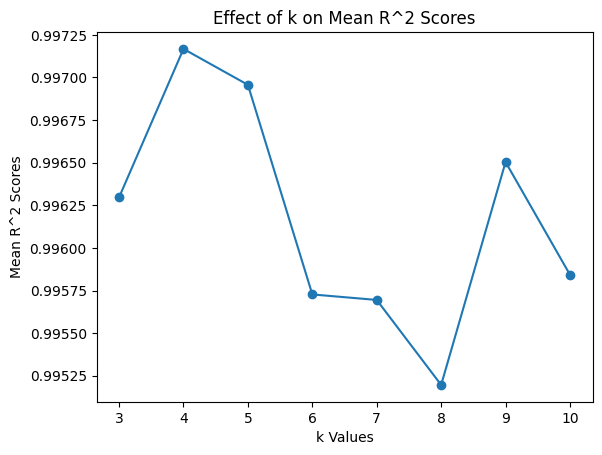

In [188]:
# Range of k values
k_values_range = range(3, 11)

# Results storage
results = {'k_values': [], 'mean_r2_scores': []}

# Loop over k values
for k_value in k_values_range:
    cv_results, _ = cross_validation(X_train, y_train, model=RandomForestRegressor(n_estimators=50, random_state=42), k_value=k_value, feature_selection=True)
    mean_r2 = np.mean(cv_results['test_r2'])
    
    # Store results
    results['k_values'].append(k_value)
    results['mean_r2_scores'].append(mean_r2)
    
    print(f'For k={k_value}, Mean R^2: {mean_r2}')

# Plot the results
plt.plot(results['k_values'], results['mean_r2_scores'], marker='o')
plt.xlabel('k Values')
plt.ylabel('Mean R^2 Scores')
plt.title('Effect of k on Mean R^2 Scores')
plt.show()

## validation

In [192]:
pipeline_reg = check_validation(pipeline_reg_2, X_train.loc[:, ~X_train.columns.isin(selected_columns_spearman)], y_train, X_test.loc[:, ~X_test.columns.isin(selected_columns_spearman)], y_test)

Test Set Mean Squared Error: 0.00251917951449667
Test Set Mean Absolute Error: 0.012682614648721535
Test Set R^2: 0.9984955460659218


## Model c_B

In [16]:
# Split the dataset into training and testing sets
df_resampled = df_resampled.sort_values('timestamp')
X_train, X_test, y_train, y_test = train_test_split(df_resampled.drop(columns=["conti_Cb", "conti_Ca", "timestamp"]), df_resampled["conti_Cb"], shuffle=False, test_size=0.2, random_state=42)

### Removing highly correlated features

In [17]:
cv_results_ca, pipeline_reg = cross_validation(X_train.loc[:, ~X_train.columns.isin(selected_columns_spearman)], y_train, RandomForestRegressor(n_estimators=50, random_state=42))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-Validation Mean Squared Error Scores: [-0.03220645 -0.02697912 -0.00714091 -0.00426955 -0.00255498]
Mean Mean Squared Error: -0.014630202808489787
Cross-Validation Mean Absolute Error Scores: [-0.09163044 -0.07071971 -0.0258055  -0.0264184  -0.01324028]
Mean Mean Absolute Error: -0.045562865005222844
Cross-Validation R^2 Scores: [0.99047029 0.99668675 0.99599496 0.99846644 0.99853909]
Mean R^2: 0.9960315048882435


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


In [18]:
pipeline_reg = check_validation(pipeline_reg, X_train, y_train, X_test, y_test)

Test Set Mean Squared Error: 0.03675933176429827
Test Set Mean Absolute Error: 0.03234125051422751
Test Set R^2: 0.9823750104435914


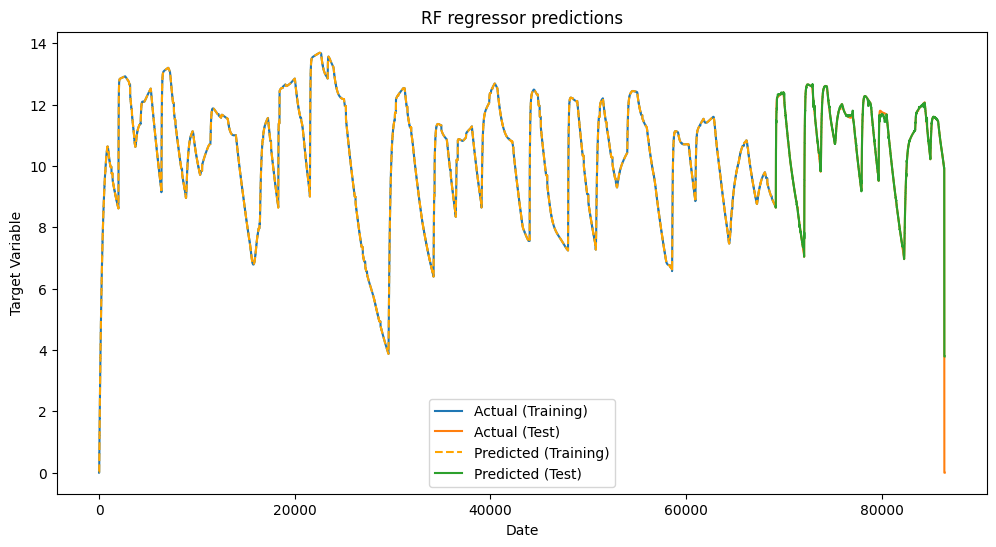

In [196]:
train_predictions = pipeline_reg.predict(X_train)
test_predictions = pipeline_reg.predict(X_test)
# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Actual (Training)')
plt.plot(X_test.index, y_test, label='Actual (Test)')
plt.plot(X_train.index, train_predictions, label='Predicted (Training)', linestyle='--', color='orange')
plt.plot(X_test.index, test_predictions, label='Predicted (Test)')
plt.title('RF regressor predictions')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

In [19]:
X=X_train.loc[:, ~X_train.columns.isin(selected_columns_spearman)]
# Create a SHAP explainer using the trained model
explainer = shap.Explainer(pipeline_reg.named_steps['model'], X)

# Use the explainer to compute SHAP values for your dataset
shap_values = explainer.shap_values(X)


In the future `np.bool` will be defined as the corresponding NumPy scalar.


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
# Generate a SHAP summary plot
shap.summary_plot(shap_values, X_train.loc[:, ~X_train.columns.isin(selected_columns_spearman)])

## Arima

In [198]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def arima_cross_validation(X_train, y_train, order=(1, 1, 1), cv_splits=5):
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    mse_scores = []
    mae_scores = []
    r2_scores = []

    for train_index, test_index in tscv.split(X_train):
        train_X, test_X = X_train.iloc[train_index], X_train.iloc[test_index]
        train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]

        # Fit ARIMA model
        arima_model = ARIMA(train_y, order=order)
        arima_fit = arima_model.fit()

        # Make predictions
        predictions = arima_fit.predict(start=len(train_X), end=len(train_X) + len(test_X) - 1, dynamic=False)

        # Evaluate predictions
        mse = mean_squared_error(test_y, predictions)
        mae = mean_absolute_error(test_y, predictions)
        r2 = r2_score(test_y, predictions)

        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)

    print(f'Cross-Validation Mean Squared Error Scores: {mse_scores}')
    print(f'Mean Mean Squared Error: {np.mean(mse_scores)}')

    print(f'Cross-Validation Mean Absolute Error Scores: {mae_scores}')
    print(f'Mean Mean Absolute Error: {np.mean(mae_scores)}')

    print(f'Cross-Validation R^2 Scores: {r2_scores}')
    print(f'Mean R^2: {np.mean(r2_scores)}')

# Assuming X_train and y_train are your feature and target variables
arima_cross_validation(X_train.loc[:, ~X_train.columns.isin(selected_columns_spearman)], y_train, order=(2, 1, 1), cv_splits=5)


Cross-Validation Mean Squared Error Scores: [4.037852040876001, 21.910144832021906, 2.3158130391912657, 4.970555634804493, 6.674284813489157]
Mean Mean Squared Error: 7.981730072076564
Cross-Validation Mean Absolute Error Scores: [1.5081488291132947, 3.748695179943327, 1.1522982213709216, 1.8961861105193756, 2.329341570381899]
Mean Mean Absolute Error: 2.1269339822657636
Cross-Validation R^2 Scores: [-0.19477816933026437, -1.6907395060763375, -0.2988425075393335, -0.7853541591236024, -2.8162904472028036]
Mean R^2: -1.1572009578544684


In [88]:
def arima_predict(X_train, y_train, X_test, order=(1, 1, 1)):
    # Fit ARIMA model on the entire training set
    arima_model = ARIMA(y_train, order=order)
    arima_fit = arima_model.fit()

    # Make predictions on the test set
    predictions = arima_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, dynamic=False)

    return predictions

# Assuming X_train and y_train are your feature and target variables
# Assuming X_test is your test set
predictions = arima_predict(X_train, y_train, X_test, order=(2, 1, 1))

In [204]:
from itertools import product

def arima_grid_search(X_train, y_train, p_values, d_values, q_values, cv_splits=5):
    # Generate all possible combinations of p, d, and q values
    param_grid = product(p_values, d_values, q_values)
    
    best_score = float('inf')
    best_params = None
    
    for params in param_grid:
        p, d, q = params
        
        # Perform cross-validation with ARIMA
        cv_results = arima_cross_validation(X_train, y_train, order=(p, d, q), cv_splits=cv_splits)
        
        # Calculate mean squared error (you can use other metrics)
        try:
            mse = np.mean(cv_results['test_neg_mean_squared_error'])
        except TypeError:
            mse=-100000
            
        
        # Update best parameters if the current model performs better
        if mse < best_score:
            best_score = mse
            best_params = params
    
    print(f'Best Hyperparameters: {best_params}')
    print(f'Best Mean Squared Error: {best_score}')

# Example usage with a limited search space
p_values = [1, 2]
d_values = [1]
q_values = [1, 2]

arima_grid_search(X_train.loc[:, ~X_train.columns.isin(selected_columns_spearman)], y_train, p_values, d_values, q_values)


Cross-Validation Mean Squared Error Scores: [4.037852040867567, 21.910144832021906, 2.3158130391902803, 4.970555634790005, 6.674284813489157]
Mean Mean Squared Error: 7.981730072071784
Cross-Validation Mean Absolute Error Scores: [1.5081488291115233, 3.748695179943327, 1.1522982213706203, 1.8961861105170883, 2.329341570381899]
Mean Mean Absolute Error: 2.126933982264892
Cross-Validation R^2 Scores: [-0.1947781693277688, -1.6907395060763375, -0.29884250753878083, -0.7853541591183986, -2.8162904472028036]
Mean R^2: -1.1572009578528177
Cross-Validation Mean Squared Error Scores: [4.037852040855677, 21.910144832021906, 2.31581303918916, 4.970555634775342, 6.674284813489157]
Mean Mean Squared Error: 7.981730072066249
Cross-Validation Mean Absolute Error Scores: [1.508148829109027, 3.748695179943327, 1.1522982213702777, 1.8961861105147748, 2.329341570381899]
Mean Mean Absolute Error: 2.1269339822638615
Cross-Validation R^2 Scores: [-0.19477816932425074, -1.6907395060763375, -0.29884250753815

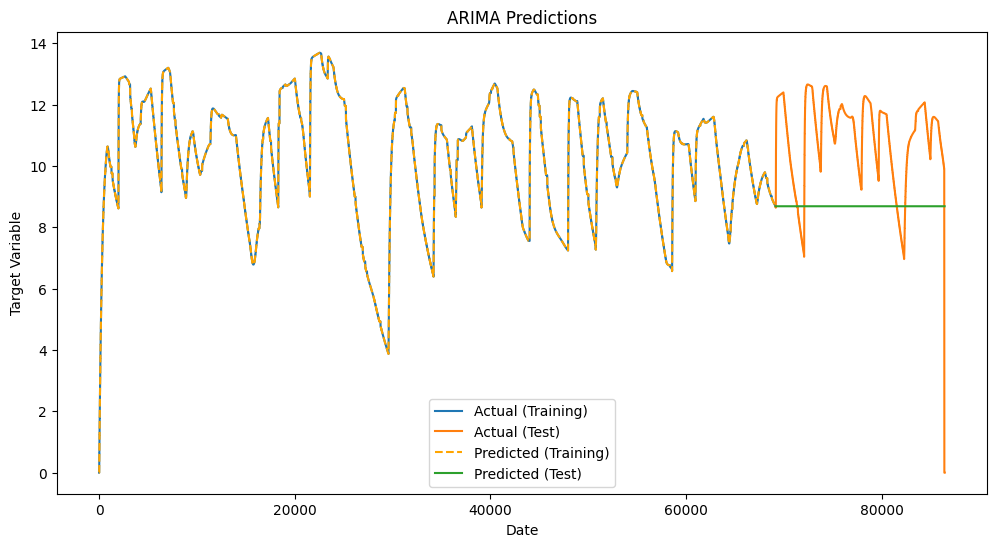

In [201]:
def arima_predict(X_train, y_train, X_test, order=(1, 1, 1)):
    # Fit ARIMA model on the entire training set
    arima_model = ARIMA(y_train, order=order)
    arima_fit = arima_model.fit()

    # Make predictions on both training and test sets
    train_predictions = arima_fit.predict(start=0, end=len(X_train) - 1, dynamic=False)
    test_predictions = arima_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, dynamic=False)

    return train_predictions, test_predictions

# Assuming X_train and y_train are your feature and target variables
# Assuming X_test is your test set
train_predictions, test_predictions = arima_predict(X_train.loc[:, ~X_train.columns.isin(selected_columns_spearman)], y_train, X_test, order=(2, 1, 1))

# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Actual (Training)')
plt.plot(X_test.index, y_test, label='Actual (Test)')
plt.plot(X_train.loc[:, ~X_train.columns.isin(selected_columns_spearman)].index, train_predictions, label='Predicted (Training)', linestyle='--', color='orange')
plt.plot(X_test.index, test_predictions, label='Predicted (Test)')
plt.title('ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

# 5. The operator sees a familiar trend

In [205]:
conti_Ca_observed = np.array([
    3.6348, 3.6302, 3.5898, 3.5495, 3.6168, 3.5765, 3.6079, 3.5321, 3.5634,
    3.5235, 3.5903, 3.5151, 3.5850, 3.5518, 3.5202, 3.5245, 3.5633, 3.6001,
    3.5982, 3.5923, 3.5464
])

In [206]:
# Calculate the absolute differences using broadcasting
differences = np.abs(np.array(df_resampled['conti_Ca'])[:, np.newaxis] - conti_Ca_observed)

# Find the index with the minimum difference
closest_row_index = np.argmin(differences, axis=0)

# Access the entire row with the closest values
closest_row = df_resampled.iloc[closest_row_index]

# Print the result
print("Closest Rows:")
closest_row["conti_Ca"]

Closest Rows:


71280    3.634738
6243     3.629999
16371    3.589835
16401    3.549546
16353    3.616926
16380    3.576543
63861    3.607873
49797    3.532059
16389    3.563416
77904    3.523453
71253    3.590047
32739    3.515282
71250    3.585051
16404    3.551821
64857    3.520725
42975    3.524587
16413    3.563340
46344    3.600115
69147    3.598535
18192    3.592529
16425    3.546387
Name: conti_Ca, dtype: float64

In [207]:
closest_row_index

array([71280,  6243, 16371, 16401, 16353, 16380, 63861, 49797, 16389,
       77904, 71253, 32739, 71250, 16404, 64857, 42975, 16413, 46344,
       69147, 18192, 16425])